# Men's College Basketball Score Prediction
WORK IN PROGRESS: This notebook demonstrates feature engineering and a predictive model for men's college basketball scores using publicly available data. Current features include team statistics, plus player statisitics split by starters and bench players. With this base set of features, the prediction model is achieving an RMSE of less than 4.5.

In [ ]:
!pip install cbbpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.3 MB/s eta 0:00:00


In [ ]:
import cbbpy.mens_scraper as cbb
import numpy as np
import pandas as pd
import xgboost as xgb

## Data Ingestion

In [ ]:
# Data cleaning steps
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
  # Since we run eval() on the {home|away}_record columns, and eval()
  # fails on empty strings, just remove any rows with empty values.
  df = df[df['home_record'] != '']
  df = df[df['away_record'] != '']
  df = df.dropna(subset=['home_record', 'away_record'])
  return df

In [ ]:
# Data transform steps
def xfm_data(df: pd.DataFrame) -> pd.DataFrame:
  # Apply eval() to each {home|away}_record. Since each record value is stored
  # in the format like, "3-5", eval() will treat it as an arithmetic problem
  # and return the plus/minus integer value, e.g., -2.
  df['home_record_plusminus'] = df['home_record'].apply(eval)
  df['away_record_plusminus'] = df['away_record'].apply(eval)
  # Convert game day to datetime so we can sort it to make sure cumlative stats
  # are in order. Use dayofweek and hour as features.
  df['game_day_dt'] = pd.to_datetime(df['game_day'])
  df['game_dow'] = df['game_day_dt'].dt.dayofweek
  game_time_dt = pd.to_datetime(df['game_time'].str[:-4], format='%I:%M %p')
  df['game_hour'] = game_time_dt.dt.hour
  return df

In [ ]:
# Data has been downloaded to CSV files using mens_scrapper.get_games_conference()
# for the 2024 season so that reruns of this notebook are quicker. However the
# CSV files need to be uploaded each time.
conference_prefixes = [
    'acc_24_',
    'americaeast_24_',
    'asun_24_',
    'atlantic10_24_',
    'big10_24_',
    'big12_24_',
    'bigeast_24_',
    'bigsky_24_',
    'bigsouth_24_',
    'bigwest_24_',
    'caa_24_',
    'confusa_24_',
    'horizon_24_',
    'ivy_24_',
    'maac_24_',
    'meac_24_',
    'midamerican_24_',
    'midcontinent_24_',
    'missourivalley_24_',
    'mtnwest_24_',
]

In [ ]:
# Used cbbpy to download data to CSV files, then read them locally to avoid scrapping each time.
info_24_df = pd.DataFrame()
info_files = [f'{c}info.csv' for c in conference_prefixes]
for info_file in info_files:
  csv_df = pd.read_csv(info_file)
  info_24_df = pd.concat([info_24_df, csv_df])

info_24_df = clean_data(info_24_df)
info_24_df = xfm_data(info_24_df)
info_24_df.shape

(7259, 35)

In [ ]:
box_24_df = pd.DataFrame()
box_files = [f'{c}box.csv' for c in conference_prefixes]
for box_file in box_files:
  csv_df = pd.read_csv(box_file)
  box_24_df = pd.concat([box_24_df, csv_df])

In [ ]:
# Parse data to get a list of all unique teams.
def get_teams(df: pd.DataFrame) -> pd.DataFrame:
  home_df = df[df['is_conference'] == True][['home_team', 'home_id']]
  home_df = home_df.rename(columns={'home_team': 'team', 'home_id': 'team_id'})
  home_df['team_id'] = home_df['team_id'].astype(int)
  away_df = df[df['is_conference'] == True][['away_team', 'away_id']]
  away_df = away_df.rename(columns={'away_team': 'team', 'away_id': 'team_id'})
  away_df['team_id'] = away_df['team_id'].astype(int)
  teams_df = pd.concat([home_df, away_df])
  return teams_df.drop_duplicates(subset=['team_id'], keep='first').sort_values(by=['team']).reset_index(drop=True)

In [ ]:
teams_df = get_teams(info_24_df)
teams_df

,team,team_id
0,Air Force Falcons,2005
1,Akron Zips,2006
2,Austin Peay Governors,2046
3,BYU Cougars,252
4,Ball State Cardinals,2050
...,...,...
211,Wright State Raiders,2750
212,Wyoming Cowboys,2751
213,Xavier Musketeers,2752
214,Yale Bulldogs,43


## Feature Engineering

In [ ]:
box_feature_col_names = ['fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk']
info_feature_col_names = ['score', 'record', 'win', 'game_dow', 'game_hour']

In [ ]:
def get_team_info_columns(row: pd.Series, team: str) -> pd.Series:
  # When iterating over the entire season, the team we are looking for could be
  # home, away or neither. Return an empty Series when not found so we can drop
  # None values.
  h_or_a = None
  if row['home_team'] == team:
    h_or_a = 'home'
  if row['away_team'] == team:
    h_or_a = 'away'
  if h_or_a is None:
    return pd.Series()
  # Convert win to 1 or 0
  win = row['home_win'] if h_or_a == 'home' else not row['home_win']
  return pd.Series({
      'game_id': row['game_id'],
      'team': row[f'{h_or_a}_team'],
      'score': row[f'{h_or_a}_score'],
      'record': row[f'{h_or_a}_record_plusminus'],
      'win': int(win),
      'game_day_dt': row['game_day_dt'],
      'game_dow': row['game_dow'],
      'game_hour': row['game_hour'],
  })

def get_team_info(team: str) -> pd.DataFrame:
  team_info_df = info_24_df.apply(get_team_info_columns, args=(team,), axis=1)
  team_info_df = team_info_df.dropna()
  team_info_df = team_info_df.sort_values(by=['game_day_dt'])
  team_info_df = team_info_df.drop_duplicates(subset=['game_id'], keep='first')
  return team_info_df

In [ ]:
def get_single_game_players(game_id: float, team: str) -> pd.DataFrame:
  return box_24_df.loc[
      (box_24_df['game_id'] == game_id)
      & (box_24_df['team'] == team)
      & (box_24_df['position'] != 'TOTAL')]

def get_game_range_players(game_range: list, team: str) -> pd.DataFrame:
  # This will return all rows for a range of games so that we can get the
  # cumlative sums of each stat over different weeks of the season.
  return box_24_df.loc[
      (box_24_df['game_id'].isin(game_range))
      & (box_24_df['team'] == team)
      & (box_24_df['position'] != 'TOTAL')]

def get_player_game_stats(players_df: pd.DataFrame, s_prefix, b_prefix: str):
  # Divide player stats by starters and bench players
  starters_df = players_df.loc[players_df['starter'] == True]
  bench_df = players_df.loc[players_df['starter'] == False]
  starters_totals_s = starters_df[['min', 'pts'] + box_feature_col_names].sum()
  bench_totals_s = bench_df[['min', 'pts'] + box_feature_col_names].sum()
  s_row_values = starters_totals_s.to_numpy().reshape(1, -1)
  s_col_names = [f'{s_prefix}{col}' for col in starters_totals_s.index]
  b_row_values = bench_totals_s.to_numpy().reshape(1, -1)
  b_col_names = [f'{b_prefix}{col}' for col in bench_totals_s.index]
  return pd.DataFrame(
      np.concatenate((s_row_values, b_row_values), axis=1),
      columns=s_col_names + b_col_names)

def get_player_data(game_ids: list, team: str):
  player_data_df = pd.DataFrame()
  for i in range(1, len(game_ids) + 1):
    game_range = game_ids[:i]
    game_id = game_range[-1]
    single_game_players_df = get_single_game_players(game_id, team)
    player_game_stats_df = get_player_game_stats(single_game_players_df, 'starter_', 'bench_')
    player_game_stats_df.insert(0, 'roster', len(single_game_players_df))
    player_game_stats_df.insert(0, 'team', team)
    player_game_stats_df.insert(0, 'game_id', game_id)
    game_range_players_df = get_game_range_players(game_range, team)
    cuml_player_game_stats_df = get_player_game_stats(game_range_players_df, 'cuml_starter_', 'cuml_bench_')
    cuml_player_game_stats_df.insert(0, 'team', team)
    cuml_player_game_stats_df.insert(0, 'game_id', game_id)
    game_stats_df = player_game_stats_df.merge(cuml_player_game_stats_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
    player_data_df = pd.concat([player_data_df, game_stats_df])
  return player_data_df


In [ ]:
# Each game includes a row for the total team stats. These rows are designated
# by the "position" column value set to "TOTAL". Example:
# | game_id	  | team        | player | player_id | position | starter | min | fgm	...	pts |
# | 401641117	| UNLV Rebels | TEAM   | TOTAL     | TOTAL    | False   | NaN | 25  ...	66  |
team_total_box_rows_df = box_24_df.loc[box_24_df['position'] == 'TOTAL'][['game_id', 'team'] + box_feature_col_names]

In [ ]:
# Collect all game data into a single dataset frame
dataset_df = pd.DataFrame()
for team in list(teams_df['team']):
  team_info_df = get_team_info(team)
  team_info_df = team_info_df.merge(team_total_box_rows_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
  player_data_df = get_player_data(list(team_info_df['game_id']), team)
  team_df = team_info_df.merge(player_data_df, left_on=['game_id', 'team'], right_on=['game_id', 'team'])
  # Our target value is the score of the next game, so shift all scores
  # backwards by one row to correspond with the previous game.
  team_df['target_score'] = team_df['score'].shift(-1)
  # Shifting leaves a NaN value for the last row so drop it.
  team_df = team_df.dropna()
  dataset_df = pd.concat([dataset_df, team_df])

print(dataset_df.columns)

Index(['game_id', 'team', 'score', 'record', 'win', 'game_day_dt', 'game_dow',
       'game_hour', 'fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'roster', 'starter_min',
       'starter_pts', 'starter_fgm', 'starter_fga', 'starter_2pm',
       'starter_2pa', 'starter_3pm', 'starter_3pa', 'starter_ftm',
       'starter_fta', 'starter_oreb', 'starter_dreb', 'starter_reb',
       'starter_ast', 'starter_stl', 'starter_blk', 'bench_min', 'bench_pts',
       'bench_fgm', 'bench_fga', 'bench_2pm', 'bench_2pa', 'bench_3pm',
       'bench_3pa', 'bench_ftm', 'bench_fta', 'bench_oreb', 'bench_dreb',
       'bench_reb', 'bench_ast', 'bench_stl', 'bench_blk', 'cuml_starter_min',
       'cuml_starter_pts', 'cuml_starter_fgm', 'cuml_starter_fga',
       'cuml_starter_2pm', 'cuml_starter_2pa', 'cuml_starter_3pm',
       'cuml_starter_3pa', 'cuml_starter_ftm', 'cuml_starter_fta',
       'cuml_starter_oreb', 'cuml_starter_dreb', 'cuml_starter

In [ ]:
dataset_df = dataset_df.drop_duplicates(subset=['game_id', 'team', 'game_day_dt'], keep='first')
features_df = dataset_df.drop(['game_id', 'team', 'game_day_dt', 'target_score'], axis=1)
target_df = dataset_df['target_score']
print(features_df.shape)
print(target_df.shape)

(6860, 84)
(6860,)


In [ ]:
# train, eval, test split
from sklearn.model_selection import train_test_split

train_x, testeval_x, train_y, testeval_y = train_test_split(features_df, target_df, test_size=0.2)
print('Train:')
print(train_x.shape)
print(train_y.shape)
eval_x, test_x, eval_y, test_y = train_test_split(testeval_x, testeval_y, test_size=0.5)
print('Eval:')
print(eval_x.shape)
print(eval_y.shape)
print('Test:')
print(test_x.shape)
print(test_y.shape)


Train:
(5488, 84)
(5488,)
Eval:
(686, 84)
(686,)
Test:
(686, 84)
(686,)


## Model Training

In [ ]:
model = xgb.XGBRegressor(eval_metric='rmse')
model.fit(train_x, train_y, eval_set=[(eval_x, eval_y)], verbose=True)
model.get_booster().feature_names = features_df.columns.to_list()

[0]	validation_0-rmse:9.06333
[1]	validation_0-rmse:7.16343
[2]	validation_0-rmse:5.99682
[3]	validation_0-rmse:5.29356
[4]	validation_0-rmse:4.85560
[5]	validation_0-rmse:4.62961
[6]	validation_0-rmse:4.56262
[7]	validation_0-rmse:4.52316
[8]	validation_0-rmse:4.43164
[9]	validation_0-rmse:4.36557
[10]	validation_0-rmse:4.35871
[11]	validation_0-rmse:4.36441
[12]	validation_0-rmse:4.35521
[13]	validation_0-rmse:4.29907
[14]	validation_0-rmse:4.31901
[15]	validation_0-rmse:4.31632
[16]	validation_0-rmse:4.29638
[17]	validation_0-rmse:4.29622
[18]	validation_0-rmse:4.31025
[19]	validation_0-rmse:4.29962
[20]	validation_0-rmse:4.28542
[21]	validation_0-rmse:4.28916
[22]	validation_0-rmse:4.29936
[23]	validation_0-rmse:4.32034
[24]	validation_0-rmse:4.32592
[25]	validation_0-rmse:4.32354
[26]	validation_0-rmse:4.31368
[27]	validation_0-rmse:4.31148
[28]	validation_0-rmse:4.30276
[29]	validation_0-rmse:4.28845
[30]	validation_0-rmse:4.32409
[31]	validation_0-rmse:4.32703
[32]	validation_0-

## Feature Importance

Looking at the post-training feature importance, the score of the previous game is the dominant feature for predicting the score of the next game. Our player stats divided by starters and bench rate highly as a significant differentiator.

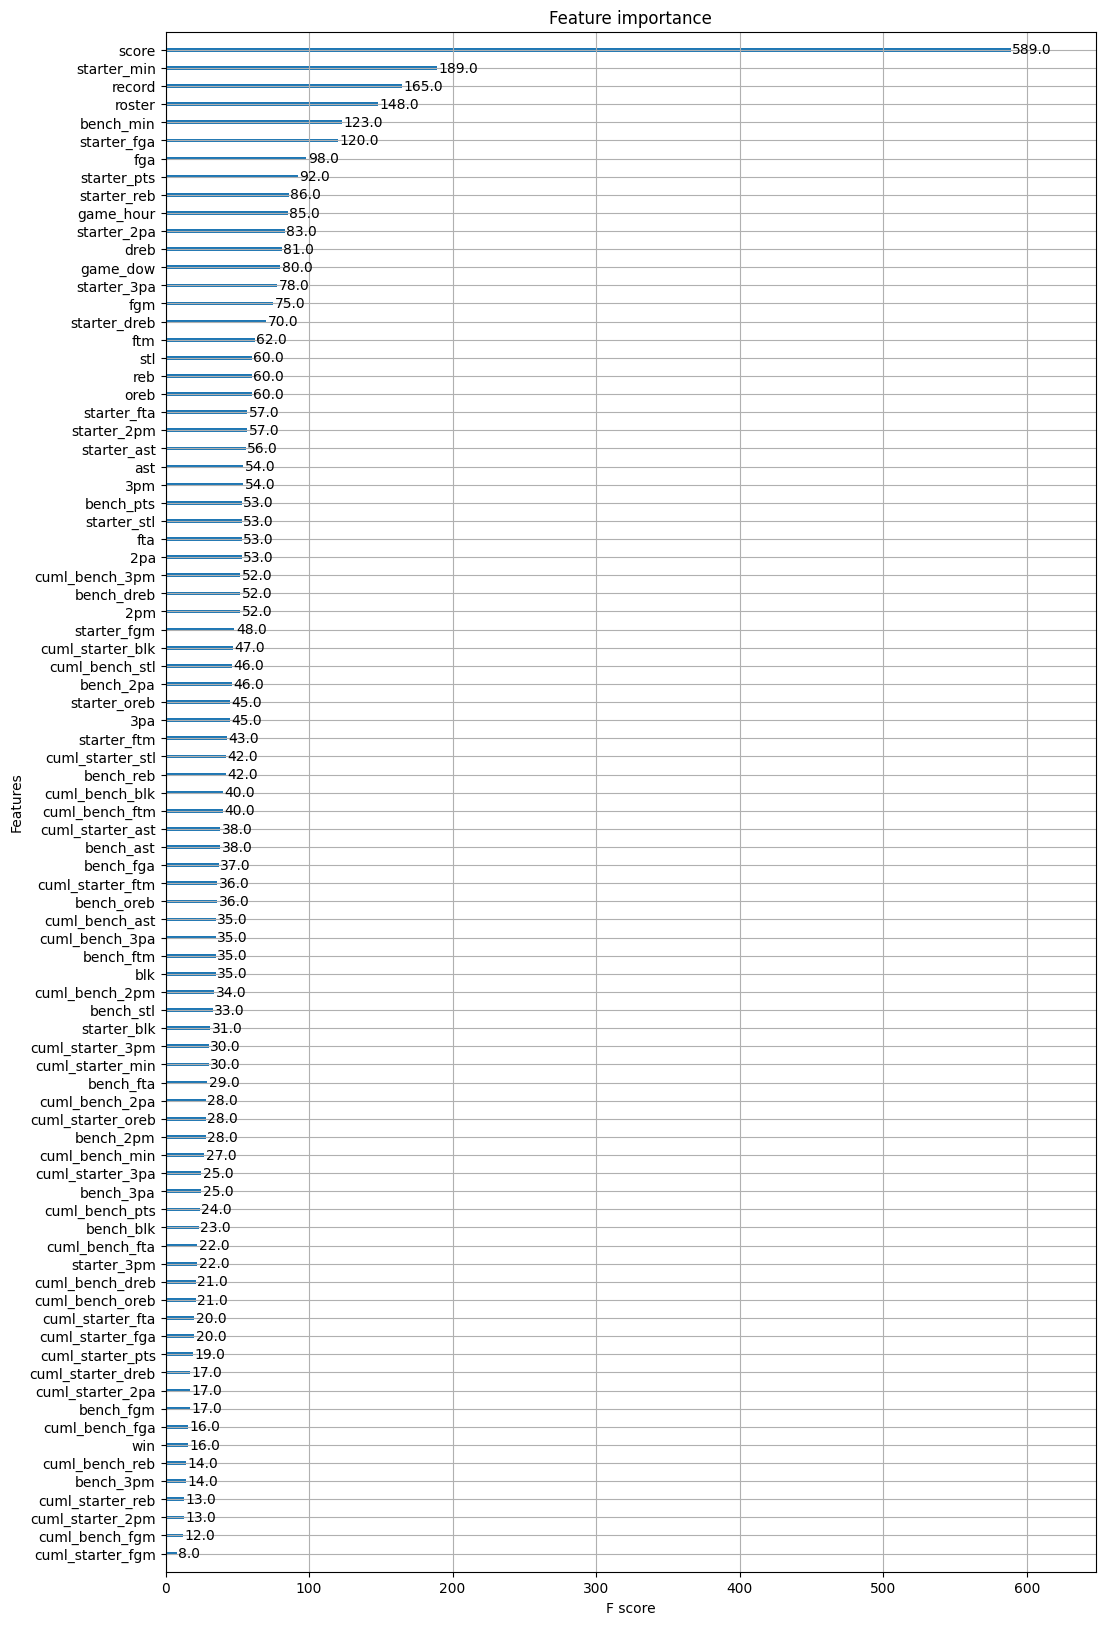

In [ ]:
# Display feature importance.
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,20))
plot_importance(model, max_num_features=int(features_df.shape[0]/2), ax=ax)
plt.show()

Try a k-fold experiment to see if we get a similar RMSE as during model training.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, features_df, target_df, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean RMSE: 4.895 (0.373)


In [ ]:
from sklearn.metrics import root_mean_squared_error

preds = model.predict(test_x)
rmse = root_mean_squared_error(test_y, preds)
print(f'Test RMSE: {rmse}')

Test RMSE: 5.14522841192493


In [ ]:
comparison_df = pd.DataFrame({'actual': test_y, 'predicted': preds})
comparison_df['diff'] = comparison_df['actual'] - comparison_df['predicted']

The majority of predictions are accurate, but the stddev spread has a lot of outliers

<Axes: >

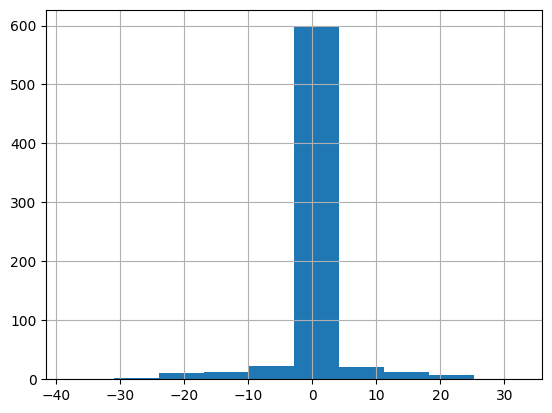

In [ ]:
comparison_df['diff'].hist()

In [ ]:
comparison_df.describe()

,actual,predicted,diff
count,686.000000,686.000000,686.000000
mean,71.908163,71.949226,-0.041065
std,11.484500,10.563363,5.148819
min,41.000000,41.702068,-37.992104
25%,64.000000,64.960968,-0.133881
50%,72.000000,72.093231,0.008629
75%,79.000000,78.854311,0.148407
max,113.000000,109.713783,32.370285


In [ ]:
# Percent of valus outside of 2 stddev
outside_2std = len(comparison_df.loc[
    (comparison_df['diff'] > (2 * comparison_df['diff'].std()))
    | (comparison_df['diff'] < (2 * comparison_df['diff'].std()) * -1)])
pct = (outside_2std / len(test_y)) * 100
print(f'Percent of values outside of 2 stddev: {pct}%')

Percent of values outside of 2 stddev: 6.997084548104956%


In [ ]:
count_below_1pt = len(comparison_df.loc[(comparison_df['diff'] < 1) & (comparison_df['diff'] > -1)])
under1_pct = (count_below_1pt / len(test_y)) * 100
print(f'Percent of predictions under 1pt: {under1_pct}%')

Percent of predictions under 1pt: 80.32069970845481%
